# Trabajo de Curso VC

### Autores
Kilian Armas Pérez

Pablo Segura López

La celda principal para la ejecución del trabajo se encuentra al final del documento. Las celdas anteriores van indicando los pasos que se han seguido hasta conseguir la animación final.

# Dependencias necesarias

In [ ]:
# pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html
# pip install matplotlib
# pip install numpy
# pip install opencv-python
# pip install scipy
# pip install torchsummary
# pip install h5py
# pip install tqdm
# pip install yacs
# pip install numba
# pip install scikit-image
# pip install filterpy
# pip install bpy
# Añadir al path el ffmpeg, la carpeta bin

# Generar los esqueletos 3D
El vídeo debe encontrarse en la carpeta GAST-Net/data/video. Este comando creará un archivo NPZ que contendrá los esqueletos 3D que posteriormente se usarán para la animación

In [ ]:
#python gen_skes.py --video fortnite.mp4
import subprocess
working_dir = "C:/Users/pablo/Desktop/Universidad/Cuarto/Visión por computador/Prácticas/Trabajo-VC/GAST-Net"
process = subprocess.Popen(["python",
                            "gen_skes.py",
                            "--video", "baseball.mp4"
                            ], 
                            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, cwd=working_dir)
for line in process.stdout:
    print(line,end="")

Loading YOLOv3 network.....
YOLOv3 network successfully loaded
Loading HRNet model ...
HRNet network successfully loaded
Generating 2D pose ...

100%|██████████| 277/277 [07:20<00:00,  1.59s/it]
Loading GAST-Net ...
GAST-Net successfully loaded
Generating 3D human pose ...
Saving 3D reconstruction...
Completing saving...


Comprobación del archivo npz: este archivo tiene una clave "reconstruction" con un array de dimensiones (skeletons,frames,joints,3D coordinates)

In [9]:
import numpy as np

data = np.load('./GAST-Net/output/fortnite.npz')

skeleton_data_shape = data["reconstruction"].shape
print(skeleton_data_shape)


(1, 201, 17, 3)


# Animación de prueba (Dummy)
Esta animación sirve para comprobar cómo está estructurado el fichero NPZ, así como para entender cómo se animará posteriormente en Blender.

Animación guardada como animacion_esqueleto.mp4


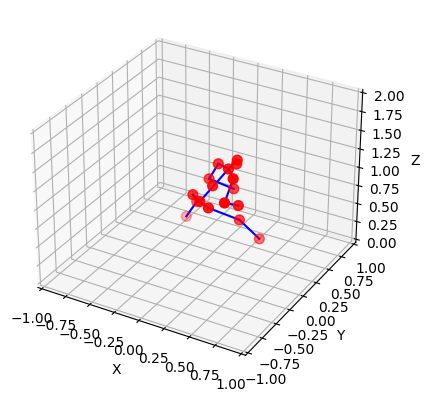

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Carga el archivo NPZ
npz_data = np.load('./GAST-Net/output/baseball.npz')
skeleton_data = npz_data["reconstruction"]  # Clave "reconstruction"

# Extrae los datos relevantes
frames = skeleton_data[0]  # Ignora la primera dimensión (número de esqueletos)
n_frames = frames.shape[0]

skeleton_connections = [
    # Pierna izquierda
    (0, 1),  # Cadera -> Pelvis I
    (1, 2),  # Pelvis I -> Rodilla I
    (2, 3),  # Rodilla I -> Tobillo I

    # Pierna derecha
    (0, 4),  # Cadera -> Pelvis D
    (4, 5),  # Pelvis D -> Rodilla D
    (5, 6),  # Rodilla D -> Tobillo D
     # Tronco
    (0, 8),  # Cadera -> Tronco (Torso)
    (8, 10),  # Tronco -> Cabeza
    (8, 11),  # Tronco -> Hombro izquierdo
    (8, 14),  # Tronco -> Hombro derecho

    # Brazo izquierdo
    (11, 12),  # Hombro izquierdo -> Codo izquierdo
    (12, 13),  # Codo izquierdo -> Muñeca izquierda
    # Brazo derecho
    (14, 15),  # Hombro derecho -> Codo derecho
    (15, 16),  # Codo derecho -> Muñeca derecha
    
]


# Configura la figura
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Animación del Esqueleto 3D")

# Función para actualizar los datos en cada frame
def update(frame_index):
    ax.clear()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([0, 2])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    # Dibuja los puntos del esqueleto
    frame = frames[frame_index]
    xs, ys, zs = frame[:, 0], frame[:, 1], frame[:, 2]
    ax.scatter(xs, ys, zs, c="red", s=50, label="Articulaciones")

    # Dibuja las conexiones del esqueleto
    for start, end in skeleton_connections:
        x_coords = [frame[start, 0], frame[end, 0]]
        y_coords = [frame[start, 1], frame[end, 1]]
        z_coords = [frame[start, 2], frame[end, 2]]
        ax.plot(x_coords, y_coords, z_coords, c="blue")

# Crea la animación
ani = FuncAnimation(fig, update, frames=n_frames, interval=50)  # 50 ms por frame

# Guardar la animación como un archivo MP4
output_path = "animacion_esqueleto.mp4"  # Cambia esto al nombre de salida deseado
writer = FFMpegWriter(fps=20, metadata={"title": "Animación Esqueleto 3D"})
ani.save(output_path, writer=writer)

print(f"Animación guardada como {output_path}")


# Animación con blender
En esta celda se realiza la animación de los esqueletos 3D usando el motor de Blender. Para ello, se utiliza el script blender_animation.py. Este script se encarga de configurar el fondo, la cámara, la luz y el personaje. Cabe destacar que el personaje está formado por polígonos. Se intentó animar un modelo 3D con rigging para representar al personaje (script blender_character_animation_test.py), pero hubo problemas y no se conseguían los resultados esperados, además de que tardaba mucho más en renderizarse que usando simples polígonos. 
Por ello, y puesto que la parte que nos interesa de este trabajo es la relacionada con la visión por computador, se decidió finalmente usar polígonos. 

In [13]:
import subprocess
import os

working_dir = os.getcwd().replace("\\","/")
process = subprocess.Popen(["C:/Program Files/Blender Foundation/Blender 4.3/blender.exe",
                            "--background",
                            "--python","blender_animation.py",
                            "--",
                            "--file", os.path.join(working_dir, "GAST-Net/output/fortnite.npz"),
                            "--color", "blue",
                            "--output",os.path.join(working_dir, "output/fortnite.mp4")], 
                            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, cwd=working_dir)
for line in process.stdout:
    print(line,end="")

Blender 4.3.2 (hash 32f5fdce0a0a built 2024-12-17 03:35:23)
Fra:1 Mem:54.28M (Peak 54.78M) | Time:00:19.87 | Rendering 1 / 64 samples
Fra:1 Mem:54.28M (Peak 54.78M) | Time:00:20.64 | Rendering 25 / 64 samples
Fra:1 Mem:54.28M (Peak 54.78M) | Time:00:21.03 | Rendering 50 / 64 samples
Fra:1 Mem:54.28M (Peak 54.78M) | Time:00:21.17 | Rendering 64 / 64 samples
Append frame 1
Time: 00:21.42 (Saving: 00:00.18)

Fra:2 Mem:54.28M (Peak 57.79M) | Time:00:00.25 | Rendering 1 / 64 samples
Fra:2 Mem:54.28M (Peak 57.79M) | Time:00:00.51 | Rendering 25 / 64 samples
Fra:2 Mem:54.28M (Peak 57.79M) | Time:00:00.78 | Rendering 50 / 64 samples
Fra:2 Mem:54.28M (Peak 57.79M) | Time:00:00.93 | Rendering 64 / 64 samples
Append frame 2
Time: 00:01.03 (Saving: 00:00.00)

Fra:3 Mem:54.28M (Peak 57.79M) | Time:00:00.26 | Rendering 1 / 64 samples
Fra:3 Mem:54.28M (Peak 57.79M) | Time:00:00.52 | Rendering 25 / 64 samples
Fra:3 Mem:54.28M (Peak 57.79M) | Time:00:00.79 | Rendering 50 / 64 samples
Fra:3 Mem:54.28M (

# Producto final
En esta celda se realiza todo el proceso de estimación del esqueleto 3D y posterior animación. El usuario solo debe indicar el nombre del vídeo original, la ruta completa del archivo final y su color de preferencia para el fondo (las opciones son rojo y azul)

In [21]:
import subprocess
import os

# VARIABLES A DECIDIR POR EL USUARIO
video_path = "fortnite.mp4"
output_path = "output/fortnite.mp4"
color = "blue"
quality = "HIGH"


working_dir = os.getcwd()
process = subprocess.Popen(["python",
                            "gen_skes.py",
                            "--video", video_path
                            ], 
                            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, cwd=working_dir + "/GAST-Net")
for line in process.stdout:
    print(line,end="")
print("Estimación de esqueletos 3D finalizada")
process = subprocess.Popen(["C:/Program Files/Blender Foundation/Blender 4.3/blender.exe",
                            "--background",
                            "--python","blender_animation.py",
                            "--",
                            "--file", os.path.join(working_dir, f"GAST-Net/output/{video_path.split(".")[0]}.npz"),
                            "--color", "blue",
                            "--output",os.path.join(working_dir, output_path),
                            "--quality", quality], 
                            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, cwd=working_dir)
for line in process.stdout:
    print(line,end="")
print("Animación generada")

Animación guardada como MP4 exitosamente.
Blender 4.3.2 (hash 32f5fdce0a0a built 2024-12-17 03:35:23)

Blender quit
